In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import scipy.stats
import seaborn as sns

In [2]:
df1 = pd.read_csv('logWithDistance2.txt',sep='|')

In [3]:
def getProcessedDF(initialdf):
    
    splitpos = []
    for index, row in initialdf.iterrows():
       timestamp = row['Time Stamp']
       if timestamp == 'Time Stamp':
            splitpos.append(index)
    dfs = np.split(initialdf, splitpos, axis=0)
    
    def deleteHead(df):
        return df.iloc[1:]
    def makeNumeric(df):
        df.RSSI = df.RSSI.apply(float)
        return df
    def averageRSSI(df):
        return df.groupby('BSSID', as_index=False).mean()
    def sortByRSSI(df):
        return df.sort_values('RSSI',ascending=False)
    def getDist(df):
        return float((df['dist'].iloc[0]))

    dfs = list(map(deleteHead,dfs))
    dists = np.array(list(map(getDist,dfs)))

    dfs = list(map(makeNumeric,dfs))
    dfs = list(map(averageRSSI,dfs))
    dfs = list(map(sortByRSSI,dfs))
    return dfs, dists # for single sample example





In [51]:
def getRankDict(prev,df,intersection=False):
        intersection = set(prev['BSSID']) & set(df['BSSID'])
        rankdict = {}
        counter = 1
        for index in range(len(df)):
            row = df.iloc[index]
            if not intersection: rankdict[row['BSSID']] = index
            else:
                if row['BSSID'] in intersection:
                    rankdict[row['BSSID']] = counter
                    counter += 1
        return rankdict

In [52]:
dfs, dists = getProcessedDF(df1)
spearmanDicts = []
for i in range(0,len(dfs)):
    spearmanDicts.append(getRankDict(dfs[0],dfs[i],intersection=False))
print(rankDicts)
# baseIndex = np.where(dists == 0)[0][0]
base = spearmanDicts[0]
move = spearmanDicts[1:]
Y = dists[1:]

[{'08:cc:68:b5:8d:f5': 1, '08:cc:68:b5:8d:f4': 2, '08:cc:68:b5:8d:f1': 3, '08:cc:68:b5:8d:f0': 4, '08:cc:68:b5:86:82': 5, '08:cc:68:b5:86:85': 6, '08:cc:68:b5:86:84': 7, '08:cc:68:b5:86:80': 8, '08:cc:68:b5:86:81': 9, '64:f6:9d:89:56:72': 10, '64:f6:9d:8e:a4:81': 11, '00:22:6b:73:a9:fa': 12, '64:f6:9d:8e:a4:80': 13, '64:f6:9d:ad:dc:80': 14, '64:f6:9d:ad:dc:81': 15, 'f4:f2:6d:22:9d:00': 16, '9c:30:5b:63:c3:31': 17, 'f4:ec:38:b3:f4:94': 18, '6c:70:9f:e6:1a:a0': 19, '08:cc:68:b4:7e:e1': 20, '30:91:8f:b6:59:ab': 21, '08:cc:68:b4:84:95': 22, '08:cc:68:b4:8c:f5': 23, '08:cc:68:b5:86:8d': 24, 'a0:63:91:de:85:45': 25, '08:cc:68:b5:86:8e': 26, 'e0:55:3d:10:35:1a': 27, '04:62:73:ae:fd:32': 28, '08:cc:68:b4:84:9b': 29, 'a0:63:91:de:85:44': 30, '08:cc:68:b5:86:8f': 31, '08:cc:68:b5:86:8b': 32, '08:cc:68:b5:86:8a': 33, '08:cc:68:b4:84:9f': 34, '64:f6:9d:8e:a4:8e': 35, '00:22:6b:73:a9:fb': 36, 'bc:30:7e:07:ef:b2': 37, '08:cc:68:b4:84:9a': 38, '64:f6:9d:8e:a4:8f': 39, '90:72:40:12:39:bc': 40, '08:cc:

In [53]:
def getSpearmans(dict1,dict2):
    intersection = set(dict1.keys()) & set(dict2.keys())
    result = []
    for k in intersection:
        result.append((dict1[k],dict2[k]))
    result = np.array(result)
    resValue = scipy.stats.spearmanr(result)[0]
    return resValue

In [54]:
def  getJacard(dict1,dict2):
    set1 = set(dict1.keys())
    set2 = set(dict2.keys())
    print(len(set1 & set2),len(set1),len(set2))
    jacard = len(set1 & set2) / len(set1 | set2)
    return jacard

In [55]:
spearmans = []
jacards = []
for df in move:
    spearmans.append(getSpearmans(df,base))
    jacards.append(getJacard(df,base))
    
modelInput = np.array([spearmans,jacards])

43 43 53
41 41 53
43 43 53
47 47 53
31 31 53
39 39 53
35 35 53
38 38 53
34 34 53
34 34 53
31 31 53
30 30 53
26 26 53
26 26 53
28 28 53
25 25 53
22 22 53
26 26 53
25 25 53
27 27 53
26 26 53
24 24 53
27 27 53
30 30 53
28 28 53


In [56]:
labels = Y[:,np.newaxis]
X = modelInput.swapaxes(1,0)

In [57]:
model = LinearRegression()

In [58]:
cv = cross_validate(model,X,labels,cv=10,scoring='neg_mean_squared_error', return_train_score = True)

In [59]:
cv

{'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00399566, 0.        , 0.        ]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_score': array([ -4.74107355, -24.4570598 ,  -2.69985307,  -3.00624476,
        -28.84762862, -55.15261162,  -4.9723458 , -20.74744207,
        -21.69523497, -89.48753782]),
 'train_score': array([-16.29116936, -13.77403156, -16.3269523 , -16.3095152 ,
        -13.56665996, -12.52627869, -15.61881552, -14.40553417,
        -14.34668892,  -9.88475678])}

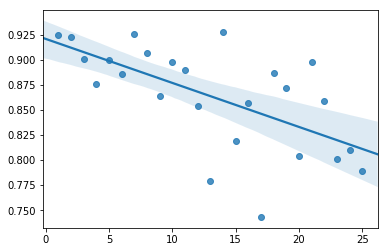

In [63]:
sns.regplot(labels[:,0],X[:,0])

In [69]:
model.fit(X,labels)
model.predict(X)

array([[ 2.37518163],
       [ 3.89728628],
       [ 3.25469364],
       [ 1.26942906],
       [11.98528221],
       [ 6.71769   ],
       [ 8.12633072],
       [ 6.64676772],
       [11.14886802],
       [ 9.88729547],
       [12.35687065],
       [14.40337342],
       [20.06354163],
       [14.56896184],
       [17.15140374],
       [17.92120339],
       [24.2707326 ],
       [16.106436  ],
       [17.38245732],
       [18.42160506],
       [15.6779596 ],
       [18.56450972],
       [18.53412513],
       [16.02708677],
       [18.24090837]])

In [62]:
model.coef

AttributeError: 'LinearRegression' object has no attribute 'coef'